In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.patches as patches
from skimage import measure
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte
from skimage import io
from skimage.feature import greycomatrix, greycoprops

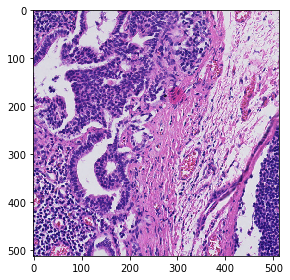

In [88]:
slide = io.imread("dataset045/有癌细胞/01_17_22.png")
io.imshow(slide)

In [99]:
slide.shape

(512, 512, 3)

In [101]:
slide = slide.flatten().reshape((512*512,3))

In [102]:
slide.shape

(262144, 3)

In [103]:
from skimage import io, measure
from sklearn.cluster import KMeans

estimator = KMeans(n_clusters=4, n_init=1, init='random')

estimator.fit(slide)
labels = estimator.labels_
print(labels.shape)

(262144,)


In [105]:
label_image = np.reshape(labels, (512, 512))

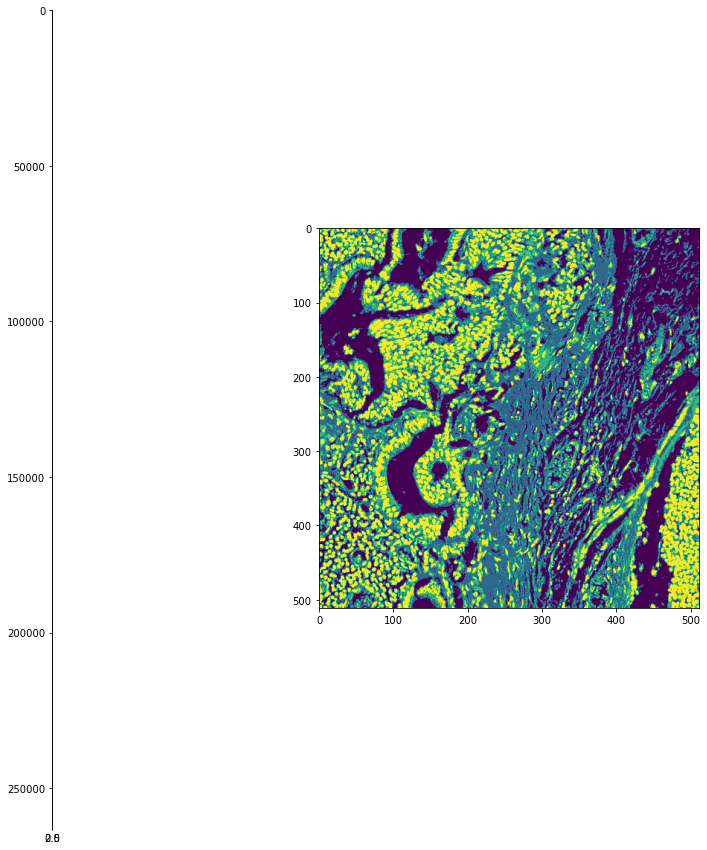

In [124]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.subplot(1,2,1)
plt.imshow(slide, cmap='gray')
plt.subplot(1,2, 2)
plt.imshow(label_image)
plt.show()

In [133]:
import nrrd
nrrd.write('dataset045/有癌细胞/label_image.nrrd', label_image, index_order='C')

In [141]:
from PIL import Image
im = Image.fromarray(label_image)
im.save("dataset045/有癌细胞/label_image.png")

In [127]:
# pip uninstall radiomics
#!pip install itk
# !pip install pynrrd

In [111]:
import SimpleITK as sitk
import itk

In [146]:
image

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7fe080e7efc0> >

In [79]:
image2 = itk.imread("dataset045/有癌细胞/label_image.png")

In [147]:
import SimpleITK as sitk

reader = sitk.ImageFileReader()
reader.SetImageIO("PNGImageIO")
reader.SetFileName("dataset045/有癌细胞/01_17_22.png")
image = reader.Execute()

In [148]:
import SimpleITK as sitk

reader = sitk.ImageFileReader()
reader.SetImageIO("PNGImageIO")
reader.SetFileName("dataset045/有癌细胞/label_image.png")
label_image = reader.Execute()

In [117]:
writer = sitk.ImageFileWriter()
writer.SetFileName("dataset045/有癌细胞/label_image.nrrd")
writer.Execute(image)

In [63]:
itk.imwrite(image, "label_image1.png")

In [154]:
import SimpleITK as sitk
from radiomics import glrlm
from radiomics import featureextractor

image = sitk.ReadImage('dataset045/有癌细胞/01_17_22.png', imageIO="PNGImageIO")
label_image = sitk.ReadImage('dataset045/有癌细胞/label_image.png', imageIO="PNGImageIO")
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor = featureextractor.RadiomicsFeatureExtractor(binWidth=20, sigma=[1, 
             2, 3], verbose=True)
# Disable all feature classes, save firstorder
extractor.disableAllFeatures()
extractor.enableFeatureClassByName('glrlm')

extractor.enableFeaturesByName(glrlm=['SRE', 'LRE','GLN','GLNN','RLN','RLNN','RP','GLV','RV','RE',
                                      'LGLRE','HGLRE','SRLGLE','SRHGLE','LRLGLRE','LRHGLRE'])
result = extractor.execute(image, label_image)

RuntimeError: Exception thrown in SimpleITK LabelStatisticsImageFilter_Execute: ../../Code/Common/include/sitkDualMemberFunctionFactory.hxx:178:
sitk::ERROR: Pixel type: vector of 8-bit unsigned integer is not supported in 2D byN3itk6simple26LabelStatisticsImageFilterE

In [177]:
test = np.array([[1,1,1]
                ,[2,0,0]
                 ,[3,0,1]])

In [204]:
glrlm = getGrayLevelRumatrix( array = test, theta = ['deg45'])
glrlm

0 degree: [[1, 1, 1], [2, 0, 0], [3, 0, 1]]
90 degree: [[1, 2, 3], [1, 0, 0], [1, 0, 1]]
45 degree: [array([1]), array([2, 1]), array([3, 0, 1]), array([0, 0]), array([1])]


array([[[1.],
        [1.],
        [0.]],

       [[4.],
        [0.],
        [0.]],

       [[1.],
        [0.],
        [0.]],

       [[1.],
        [0.],
        [0.]]])

In [201]:
from itertools import groupby
def getGrayLevelRumatrix(array, theta):
        '''
        计算给定图像的灰度游程矩阵
        参数：
        array: 输入，需要计算的图像
        theta: 输入，计算灰度游程矩阵时采用的角度，list类型，可包含字段:['deg0', 'deg45', 'deg90', 'deg135']
        glrlm: 输出，灰度游程矩阵的计算结果
        '''
        P = array
        rows, cols = P.shape
        min_pixels = np.min(P)   # 图像中最小的像素值
        run_length = max(rows, cols)   # 像素的最大游行长度
        num_level = np.max(P) - np.min(P) + 1   # 图像的灰度级数

        deg0 = [val.tolist() for sublist in np.vsplit(P, rows) for val in sublist]   # 0度矩阵统计
#         print("0 degree:", deg0)

        deg90 = [val.tolist() for sublist in np.split(np.transpose(P), cols) for val in sublist]   # 90度矩阵统计
#         print("90 degree:", deg90)
        
        diags = [P[::-1, :].diagonal(i) for i in range(-P.shape[0]+1, P.shape[1])]   #45度矩阵统计
#         print("45 degree:", diags)
        
        deg45 = [n.tolist() for n in diags]
        Pt = np.rot90(P, 3)   # 135度矩阵统计
        diags = [Pt[::-1, :].diagonal(i) for i in range(-Pt.shape[0]+1, Pt.shape[1])]
        deg135 = [n.tolist() for n in diags]

        def length(l):
            if hasattr(l, '__len__'):
                return np.size(l)
            else:
                i = 0
                for _ in l:
                    i += 1
                return i

        glrlm = np.zeros((num_level, run_length, len(theta)))   # 按照统计矩阵记录所有的数据， 第三维度表示计算角度
        for angle in theta:
            for splitvec in range(0, len(eval(angle))):
#                 print(eval(angle))
                flattened = eval(angle)[splitvec]
                answer = []
                for key, iter in groupby(flattened):   # 计算单个矩阵的像素统计信息
                    answer.append((key, length(iter)))   
                for ansIndex in range(0, len(answer)):
                    glrlm[int(answer[ansIndex][0]-min_pixels), int(answer[ansIndex][1]-1), theta.index(angle)] += 1   # 每次将统计像素值减去最小值就可以填入GLRLM矩阵中
        return glrlm
    
    

In [163]:
eval(deg0)

NameError: name 'deg0' is not defined

In [165]:
x = np.arange(16.0).reshape(4, 4)
np.vsplit(x, 2)

[array([[0., 1., 2., 3.],
        [4., 5., 6., 7.]]),
 array([[ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]])]